# RO simulations using `CRO` solver

This tutorial illustrates how to use the `pyCRO` to solve the RO model.


In [1]:
%config IPCompleter.greedy = True
%matplotlib inline
%config InlineBackend.figure_format='retina'

%load_ext autoreload
%autoreload 2

import warnings
warnings.filterwarnings("ignore")
    
import numpy as np
import matplotlib.pyplot as plt
import os
import sys
import calendar

sys.path.append(os.path.abspath("../../../"))

import pyCRO

## RO Simulation Setup

This is the simplest configuration for the RO model, using:

- **White noise**: `n_T = 1`, `n_h = 1`.

- **Linear system**: nonlinear terms (`b_T`, `c_T`, `d_T`, `b_h`) are zero. Note that All unspecified parameters default to zero.

- **Additive noise only**: no multiplicative component (`n_g = 2`).

The RO equation is written as:

- $\displaystyle \frac{dT}{dt} = RT + F_{1}h + \sigma_{T}w_{T}$


- $\displaystyle \frac{dh}{dt} = −\varepsilon{h} − F_{2}T + \sigma_{h}w_{h}$

The following block sets parameters for the RO simulation.

In [2]:
par = {'R': [-0.05],       # dT/dt=R*T (unit: month^-1)        
       'F1': [0.02],       # dT/dt=F1*h (unit: K m^-1 month^-1)
       'F2': [0.9],        # dh/dt=-F2*T (unit: m K^-1 month^-1)
       'epsilon': [0.03],  # dh/dt=-epsilon*h (unit: month^-1)
       'b_T': [],          # dT/dt=(b_T)*(T^2) (unit: K^-1 month^-1)
       'c_T': [],          # dT/dt=-(c_T)*(T^3) (unit: K^-2 month^-1)
       'd_T': [],          # dT/dt=(d_T)*(T*h) (unit: m^-1 month^-1)
       'b_h': [],          # dh/dt=-(b_h)*(T^2) (unit: K^-2 m month^-1)
       'sigma_T': [0.2],   # dT/dt=(sigma_T)*(N_T) (unit: K month^-0.5 if n_T=1, K month^-1 if n_T=0)
       'sigma_h': [1.2],   # dh/dt=(sigma_h)*(N_h) (unit: m month^-0.5 if n_h=1, m month^-1 if n_h=0)
       'B': [],            # T/dt=(sigma_T)*(1+B*T)*(N_T) or dT/dt=(sigma_T)*(1+B*H(T)*T)*(N_T) (unit: K^-1)
       'm_T': [],          # d(xi_T)/dt=-m*T*(xi_T); (unit: month^-1)
       'm_h': [],          # d(xi_h)/dt=-m*h*(xi_h); (unit: month^-1)
       'n_T': [1],         # noise type for T (0: red noise, 1: white noise) (unitless)
       'n_h': [1],         # noise type for h (0: red noise, 1: white noise) (unitless)
       'n_g': [2]}         # multiplicative noise type for T (0: linear, 1: Heaviside linear, 2: omit this option) 
                           # (note: only valid when B is not zero) (unitless)

- The following block sets additional options for the RO simulation.

In [3]:
IC = [1.0, 0.0]              # Initial conditions for T and h
N = 12 * 100                 # Simulation length in months (e.g., 100 years)
NE = 2                       # Number of ensemble members

- The RO simulation can be run by setting four settings set above: par, IC, N, and NE.
- The following block sets additional **optional settings** for the RO simulation.
- The user may skip specifying these options. If the user doesn't specify these options, the RO simulation runs with the default settings.

In [4]:
NM = "EH"                    # Optional: Numerical integration method for
                             #           RO solver "EH" (Euler–Heun, default) 
                             #           or "EM" (Euler–Maruyama)
dt = 0.1                     # Optional: Time step for numerical integration 
                             #           in months. Default = 0.1
saveat = 1.0                 # Optional: Interval for saving outputs in months. 
                             #           Default = 1.0
savemethod = "sampling"      # Optional: Output method. "sampling" saves 
                             #           instantaneous values, "mean" saves 
                             #           time-averaged values over each save 
                             #           interval. Default = "sampling"
EF = None                    # Optional: External forcing dictionary.
                             #           If EF is None (or not specified), 
                             #           it defaults to:
                             #           EF = {'E_T': [0.0], 'E_h': [0.0]}
                             #           Same format and interpretation as 
                             #           other RO parameters. Example:
                             #           EF = {'E_T': [-0.01, 0.02, np.pi],
                             #                 'E_h': [-0.01]}
noise_custom = 999           # Optional: Noise specification.
                             #   - If None or not provided: 
                             #     uses internally generated noise 
                             #     (different each run; Default)
                             #   - If an integer: uses as the random seed for
                             #     reproducible noise with the reference number
                             #   - If ndarray: user-supplied noise 
                             #     (shape must be (int(N/dt) - 1, 4))
                             #     The first two columns of the noise array are 
                             #     applied to the main T and h equations.
                             #     The last two columns are used as noise terms 
                             #     for the red noise processes.

In [5]:
pyCRO.RO_solver?

Signature:
pyCRO.RO_solver(
    par,
    IC,
    N,
    NE,
    NM='EH',
    dt=0.1,
    saveat=1.0,
    savemethod='sampling',
    EF=None,
    noise_custom=None,
    verbose=True,
)
Docstring:
Numerical solution of the Recharge Oscillator (RO) model with stochastic forcing.

This function integrates the Recharge Oscillator (RO) system numerically using
either the Euler–Maruyama (EM) or Euler–Heun (EH) scheme. It includes
deterministic dynamics, stochastic noise (white or red), and optional
external forcing. Ensemble simulations are supported, with results returned
at user-specified output intervals.

Parameters
----------
par : dict
    Dictionary of model parameters with the following keys (as 1-element arrays):

    - ``'R'`` : float
        Damping parameter.
    - ``'F1'`` : float
        Feedback parameter relating thermocline depth to SST.
    - ``'epsilon'`` : float
        Thermocline damping parameter.
    - ``'F2'`` : float
        Feedback parameter relating SST to thermoc

## RO Simulations 

### Basic Usage

**`T_ro, h_ro, _ = pyCRO.RO_solver(par, IC, N, NE)`**

This is the simplest setup:

- `T_ro` and `h_ro` are arrays with shape `(N, NE)`, where `N` is the number of time steps and `NE` is the number of ensemble members.

- The third output (`_`) is the noise time series, with shape `(N, 4, NE)`.

---------------------------------------------------------------------------------
Welcome to the CRO Solver! Your simulation setup is as follows:
---------------------------------------------------------------------------------
 - Total simulation length: N = 1200 months
 - Number of ensemble members: NE = 2
 - Numerical integration time step: dt = 0.1 months (default: 0.1)
 - Data output interval: saveat = 1.0 months (default: 1.0)
 - Initial conditions: IC = [T0, h0] = [1.0, 0.0]
 - Input parameters have the expected shapes.
 - 'n_T' = 1: White noise forcing in T; 'm_T' ignored.
 - 'n_h' = 1: White noise forcing in h; 'm_h' ignored.
 - 'n_g' = 2: Additive noise is used in the T equation; 'B' is ignored.
 - Numerical integration method: NM = 'EH' (Euler–Heun method; default)
 - Data saving method: savemethod = sampling (default)
 - External forcing is not given, therefore using
   EF = {'E_T': [0.0, 0.0, 0.0, 0.0, 0.0], 'E_h': [0.0, 0.0, 0.0, 0.0, 0.0]}.
 - noise_custom = None: System

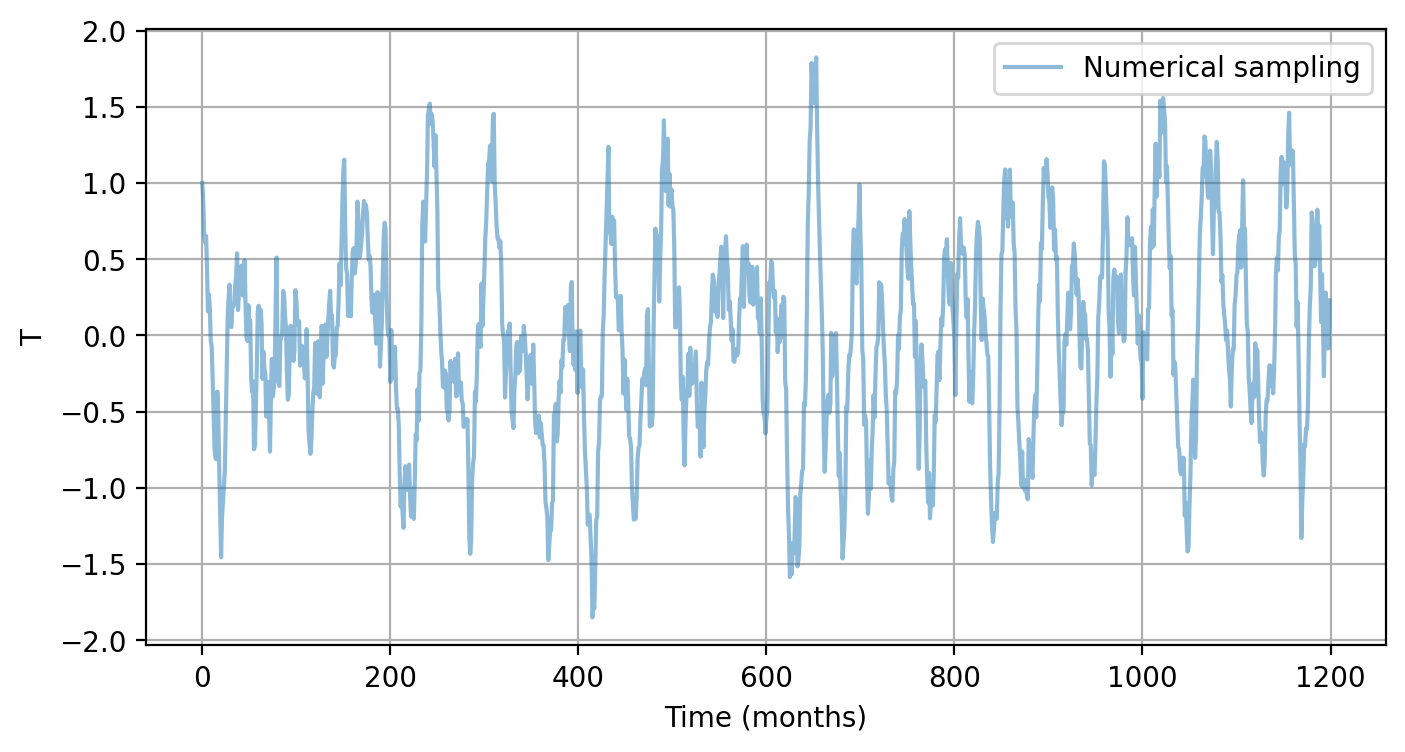

In [6]:
# Example 3-1. Solve RO with default settings
T_ro, h_ro, _ = pyCRO.RO_solver(par, IC, N, NE)   

time_axis = np.arange(0, N, saveat)
num_en = 0 # plot first ensemble member solution of T

plt.figure(figsize=(8, 4))
plt.plot(time_axis, T_ro[:, num_en],  label='Numerical sampling',  alpha=0.5)
plt.xlabel("Time (months)")
plt.ylabel("T")
plt.legend()
plt.grid()
plt.show()

### Advanced Usage

**`T_ro, h_ro, _ = pyCRO.RO_solver(par, IC, N, NE, NM)`**

**`T_ro, h_ro, _ = pyCRO.RO_solver(par, IC, N, NE, NM, dt)`**                      

**`T_ro, h_ro, _ = pyCRO.RO_solver(par, IC, N, NE, NM, dt, saveat)`**              

**`T_ro, h_ro, _ = pyCRO.RO_solver(par, IC, N, NE, NM, dt, saveat, savemethod)`**  

**`T_ro, h_ro, _ = pyCRO.RO_solver(par, IC, N, NE, NM, dt, saveat, savemethod, EF)`**                             

**`T_ro, h_ro, _ = pyCRO.RO_solver(par, IC, N, NE, NM, dt, saveat, savemethod, EF, noise_custom)`**               

- Optional arguments allow for more control.

- Each additional argument gives more precise control over the solver. 

- Refer to the previous section for details on each argument.

---------------------------------------------------------------------------------
Welcome to the CRO Solver! Your simulation setup is as follows:
---------------------------------------------------------------------------------
 - Total simulation length: N = 1200 months
 - Number of ensemble members: NE = 2
 - Numerical integration time step: dt = 0.1 months (default: 0.1)
 - Data output interval: saveat = 1.0 months (default: 1.0)
 - Initial conditions: IC = [T0, h0] = [1.0, 0.0]
 - Input parameters have the expected shapes.
 - 'n_T' = 1: White noise forcing in T; 'm_T' ignored.
 - 'n_h' = 1: White noise forcing in h; 'm_h' ignored.
 - 'n_g' = 2: Additive noise is used in the T equation; 'B' is ignored.
 - Numerical integration method: NM = 'EH' (Euler–Heun method; default)
 - Data saving method: savemethod = sampling (default)
 - External forcing is not given, therefore using
   EF = {'E_T': [0.0, 0.0, 0.0, 0.0, 0.0], 'E_h': [0.0, 0.0, 0.0, 0.0, 0.0]}.
 - noise_custom = 999: seeded 

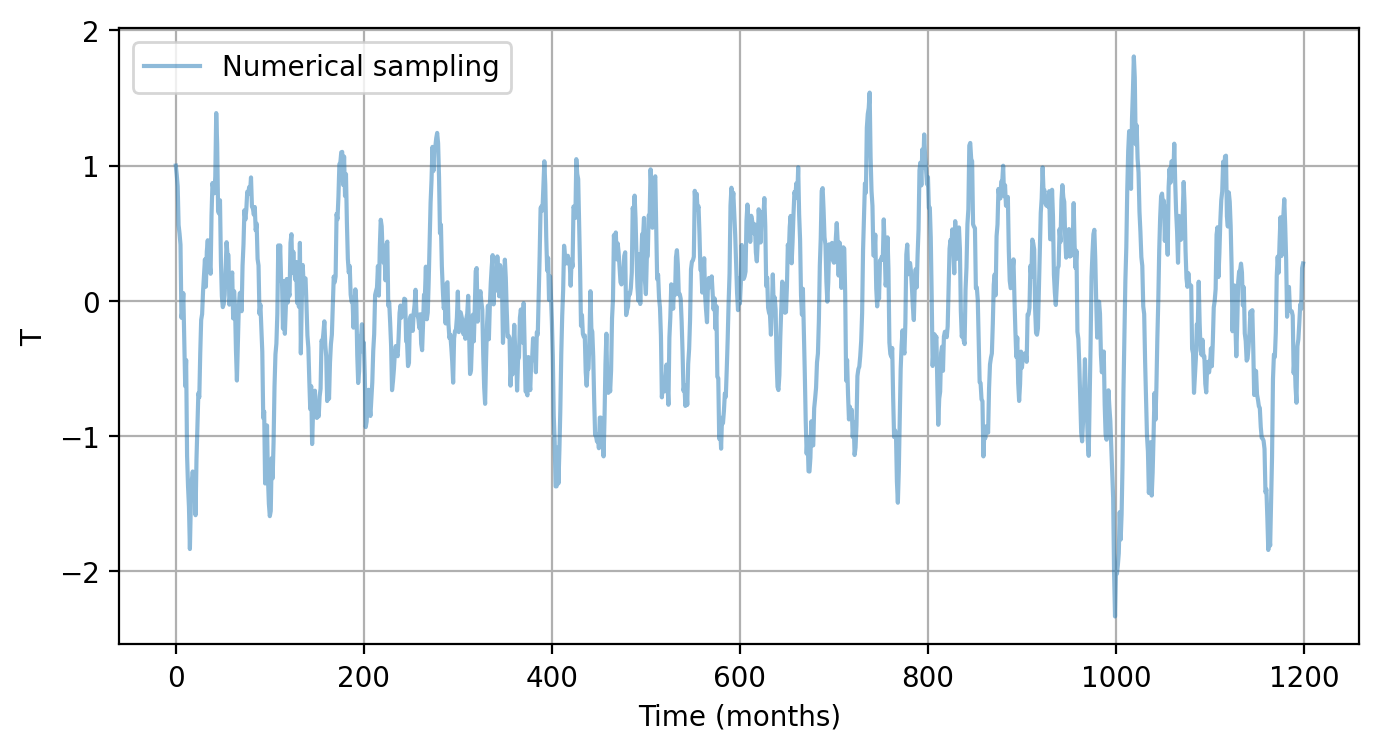

In [7]:
# Example 3-2. Solve RO with user-specified settings
T_ro, h_ro, _ = pyCRO.RO_solver(par, IC, N, NE, NM, dt, saveat, savemethod, EF, noise_custom)     

time_axis = np.arange(0, N, saveat)
num_en = 0 # plot first ensemble member solution of T

plt.figure(figsize=(8, 4))
plt.plot(time_axis, T_ro[:, num_en],  label='Numerical sampling',  alpha=0.5)
plt.xlabel("Time (months)")
plt.ylabel("T")
plt.legend()
plt.grid()
plt.show()

## Analytical Solutions of Linear RO With White Noise												  

**`T_ref, h_ref, _ = pyCRO.RO_analytic_solver(par, IC, N, NE)`**

**`T_ref, h_ref, _ = pyCRO.RO_analytic_solver(par, IC, N, NE, dt)`**               

**`T_ref, h_ref, _ = pyCRO.RO_analytic_solver(par, IC, N, NE, dt, saveat)`**       

**`T_ref, h_ref, _ = pyCRO.RO_analytic_solver(par, IC, N, NE, dt, saveat, savemethod)`**                       

**`T_ref, h_ref, _ = pyCRO.RO_analytic_solver(par, IC, N, NE, dt, saveat, savemethod, noise_custom)`**  

- This function returns the **analytical solution** for the **linear RO system** without seasonality, using **white additive noise**.  
  Its usage is structurally similar to `RO_solver`, but with the following key differences: `'NM'` (numerical method) and `'EF'` (external forcing) are **not required or accepted**.

- To ensure a **meaningful comparison** with the numerical solution from `RO_solver`, use the **same seed** for `noise_custom` in both simulations.

---------------------------------------------------------------------------------
Welcome to the CRO Solver! Your simulation setup is as follows:
---------------------------------------------------------------------------------
 - Total simulation length: N = 1200 months
 - Number of ensemble members: NE = 2
 - Numerical integration time step: dt = 0.1 months (default: 0.1)
 - Data output interval: saveat = 1.0 months (default: 1.0)
 - Initial conditions: IC = [T0, h0] = [1.0, 0.0]
 - Input parameters have the expected shapes.
 - 'n_T' = 1: White noise forcing in T; 'm_T' ignored.
 - 'n_h' = 1: White noise forcing in h; 'm_h' ignored.
 - 'n_g' = 2: Additive noise is used in the T equation; 'B' is ignored.
 - Numerical integration method: NM = 'EH' (Euler–Heun method; default)
 - Data saving method: savemethod = sampling (default)
 - External forcing is not given, therefore using
   EF = {'E_T': [0.0, 0.0, 0.0, 0.0, 0.0], 'E_h': [0.0, 0.0, 0.0, 0.0, 0.0]}.
 - noise_custom = 999: seeded 

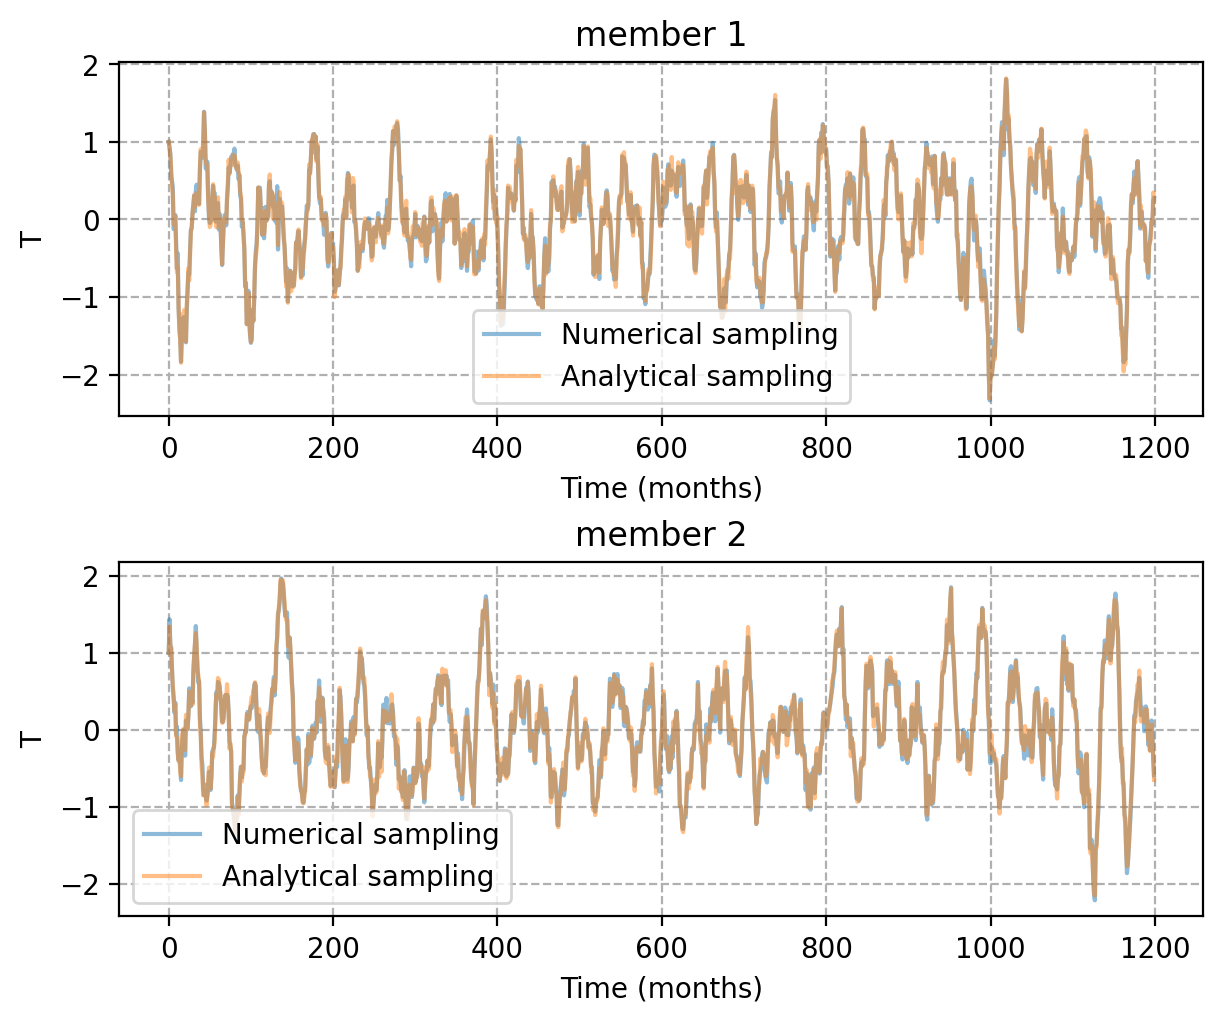

In [8]:
# Example 3-3. Compare numerical and analyticla solution
NE = 2
T_ro, h_ro, _ = pyCRO.RO_solver(par, IC, N, NE, NM, dt, saveat, savemethod, EF, noise_custom)  
T_ref, h_ref, _ = pyCRO.RO_analytic_solver(par, IC, N, NE, dt, saveat, savemethod, noise_custom)

time_axis = np.arange(0, N, saveat)

fig, axes = plt.subplots(2, 1, figsize=(6, 5), layout='compressed')
for i, ax in enumerate(axes.flat):
    ax.plot(time_axis, T_ro[:, i],  label='Numerical sampling',  alpha=0.5)
    ax.plot(time_axis, T_ref[:, i], label='Analytical sampling', alpha=0.5)
    ax.set_xlabel("Time (months)")
    ax.set_ylabel("T")
    ax.legend()
    ax.grid(ls='--')
    ax.set_title(f"member {i+1}")

## Analytical Amplitude of RO	

**`pyCRO.RO_analytic_std(par)`**

- It returns the **theoretical standard deviations** for the **linear-white-additive** configuration based on the given parameter dictionary `par`.

**`BWJ = pyCRO.RO_BWJ(par)`**

- It computes the expected **BJ** and **Wyrtki** indices, where the real part (`{BWJ.real}`) corresponds to the BJ index and the imaginary part (`{BWJ.imag}`) corresponds to the Wyrtki index, based on the given parameter dictionary `par`.
																			  

In [9]:
# Example 3-4. Compare standard deviation of numerical and analytial solutions
T_ref_std, h_ref_std = pyCRO.RO_analytic_std(par) # calculate theoretical standard deviations

T_ro, h_ro, _ = pyCRO.RO_solver(par, IC, N, NE, NM, dt, saveat, savemethod, noise_custom=None)
T_ro_std = np.std(T_ro, axis=0); h_ro_std = np.std(h_ro, axis=0)
T_ro_std_mean = np.mean(T_ro_std); h_ro_std_mean = np.mean(h_ro_std) # ensemble mean

print("Standard drviations for T (analytical):")
print(T_ref_std)
print("Standard drviations for T (ensemble mean for numerical solutions):")
print(T_ro_std_mean)
print("Standard drviations for h (analytical):")
print(h_ref_std)
print("Standard drviations for h (ensemble mean for numerical solutions):")
print(h_ro_std_mean)

# Example 3-5. Calculate BWJ Index

BWJ = pyCRO.RO_BWJ(par)
print(f"BJ index: {BWJ.real} [1/month]")
print(f"Wyrtki index: {BWJ.imag:.3f} [1/month]. "
      f"This corresponds to a periodicity of {2*np.pi/BWJ.imag:.3f} months.")

---------------------------------------------------------------------------------
Welcome to the CRO Solver! Your simulation setup is as follows:
---------------------------------------------------------------------------------
 - Total simulation length: N = 1200 months
 - Number of ensemble members: NE = 2
 - Numerical integration time step: dt = 0.1 months (default: 0.1)
 - Data output interval: saveat = 1.0 months (default: 1.0)
 - Initial conditions: IC = [T0, h0] = [1.0, 0.0]
 - Input parameters have the expected shapes.
 - 'n_T' = 1: White noise forcing in T; 'm_T' ignored.
 - 'n_h' = 1: White noise forcing in h; 'm_h' ignored.
 - 'n_g' = 2: Additive noise is used in the T equation; 'B' is ignored.
 - Numerical integration method: NM = 'EH' (Euler–Heun method; default)
 - Data saving method: savemethod = sampling (default)
 - External forcing is not given, therefore using
   EF = {'E_T': [0.0, 0.0, 0.0, 0.0, 0.0], 'E_h': [0.0, 0.0, 0.0, 0.0, 0.0]}.
 - noise_custom = None: System